# Microgrid performance simulation

Case of Microgrid project with *wind* and *solar* sources,
plus a *battery* and a *dispatchable generator*:

<img alt='schematic of a microgrid with wind and H2' src='./images/microgrid_sizing - h2.png' style='height:18em'>

Demo of main data structures and functions of [Microgrids.jl](https://github.com/Microgrids-X/Microgrids.jl).
Main steps are:

1. Describe the Microgrid project and components (including loading time series data)
2. Simulation the Microgrid
3. Analyze simulation results (technical and economic)

After this demonstration, you can go to the next step: [Microgrid sizing optimization](Microgrid_sizing_optimization.ipynb)

In [1]:
using Microgrids
using Printf, CSV, DataFrames, Statistics

[ Info: Precompiling Microgrids [bd581358-d3fa-499e-a26e-e70307242c03]


In [2]:
using PyPlot # For plotting only. Can be skipped or commented out

In [3]:
with_plots = isdefined(Main, :PyPlot)

true

## Load time series data

Read load and solar data:
- Load: real consumption data at an hourly timestep from the [Ushant island](https://en.wikipedia.org/wiki/Ushant) in 2016
- Solar and wind data comes from [PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/tools.html). See [data/SOURCES.md](data/SOURCES.md).

In [4]:
data = DataFrame(CSV.File("$(@__DIR__)/data/Ouessant_data_2016.csv"))

# Simulation steps
nsteps = length(data.Load)
@assert(nsteps == 8760) # 1 year at an hourly timestep

# Split load, solar and wind data:
Pload = data.Load # kW
Ppv1k =  data.Ppv1k ./ 1000; # convert to kW/kWp
wind_speed = data.Wind; # m/s

# Calibrate wind speed data against a mast measurement 
ws_gain = 1.059 # ratio of Mast's mean /PVGIS' mean
wind_speed = ws_gain*wind_speed

println("Time series statistics:")
@printf("- Load: min %.0f, mean %.0f, max %.0f kW\n",
        minimum(Pload), mean(Pload), maximum(Pload))
@printf("- PV capacity factor: %.2f %%\n", mean(Ppv1k)*100) # yearly capacity factor of 12% (quite low in 2016 in Ouessant)
@printf("- Wind speed: mean %.2f m/s\n", mean(wind_speed))

Time series statistics:
- Load: min 294, mean 773, max 1707 kW
- PV capacity factor: 11.83 %
- Wind speed: mean 8.03 m/s


In [5]:
Pload[1]

1453.0

Display load time series

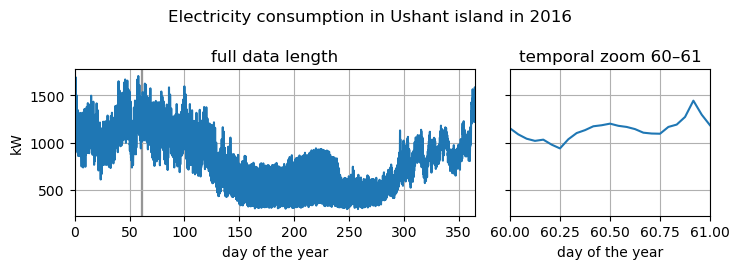

In [6]:
td = collect((0:nsteps-1)/24) # time in days

"""helper: plot time series with a temporal zoom"""
function plot_ts_zoom(t, ts; zoom, color::String, title::String, xlabel::String, ylabel::String)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7.5,2.7), sharey=true,
                                   gridspec_kw=Dict("width_ratios" => [2,1]))
    ax1.plot(t, ts, color=color)
    ax1.axvspan(zoom[1], zoom[2], color="k", alpha=0.3)
    ax2.plot(t, ts, color=color)
    ax2.set_xlim(zoom[1], zoom[2])

    ax1.grid(true)
    ax2.grid(true)
    fig.suptitle(title)
    ax1.set_xlim(t[1], t[end])
    ax1.set(
        title="full data length",
        xlabel=xlabel,
        ylabel=ylabel
    )
    ax2.set(
        title="temporal zoom $(zoom[1])–$(zoom[2])",
        xlabel=xlabel,
    )
    fig.tight_layout()
    return fig, (ax1, ax2)
end

if with_plots
    fig, (ax1, ax2) = plot_ts_zoom(
        td, Pload;
        zoom=(60,61), color="tab:blue",
        title="Electricity consumption in Ushant island in 2016",
        xlabel="day of the year", ylabel="kW"
    )
end;

### Generate wind power capacity factor time series from wind speed

We use the generic wind power curve model `capacity_from_wind` to transform wind speed time series into a capacity factor time series (normalized power).
The main parameters of this power curve are:
- Rotor swept area (m²), i.e. derived from the rotor diameter with $S=\pi(D/2)^2$
- Turbine Specific Power (W/m²), i.e. rated power compared to area

Wind turbine parameters used here are fitted to an [EWT 900 kW DW52](https://ewtdirectwind.com/products/dw52/):

In [7]:
S_D52 = pi * (52/2)^2 # rotor swept area m²
TSP_D52 = 900e3/S_D52 # W/m²
v_out = 25.0 # m/s
Cp_D52, α_D52 = 0.521, 3.1; # fitted from actual power curve

In [8]:
cf_wind = capacity_from_wind.(wind_speed; TSP=TSP_D52, Cp=Cp_D52, v_out=v_out, α=α_D52)
@printf("Wind power capacity factor: %.2f %%\n", mean(cf_wind)*100) # (pretty high in Ouessant)

Wind power capacity factor: 39.70 %


## Microgrid description

Describe the Microgrid project and its components using dedicated data structures

### Project parameters

Financial parameters like discount rate, as well as technical details like the timestep of input data.

In [9]:
lifetime = 25 # yr
discount_rate = 0.05
timestep = 1. # h

project = Project(lifetime, discount_rate, timestep, "€")

Project(25, 0.05, 1.0, "€")

Parameters chosen to be common to all Components (but they could differ)

- replacement price relative to initial investment price
- salvage price relative to initial investment price

In [10]:
replacement_price_ratio = 1.0
salvage_price_ratio = 1.0;

### Dispatchable generator (Diesel)

Used as last recourse, when there is not enough production from renewables and the battery is empty (not used in this example)

In [11]:
power_rated_gen = 0.  # rated power (kW) → /2 to see some load shedding
# fuel parameters:
fuel_intercept = 0.0 # fuel curve intercept (L/h/kW_max)
fuel_slope = 0.240 # fuel curve slope (L/h/kW)
# prices:
fuel_price = 1. # fuel price ($/L)
investment_price_gen = 400. # initial investiment price ($/kW)
om_price_gen = 0.02 # operation & maintenance price ($/kW/h of operation)
# other technical parameters
lifetime_gen = 15000. # generator lifetime (h)
load_ratio_min_gen = 0.0 # minimum load ratio ∈ [0,1]
input_unit_gen = "L" # fuel quantity unit (used in fuel price and consumption curve parameters)
output_unit_gen = "KWh"

generator = ProductionUnit(power_rated_gen,
    fuel_intercept, fuel_slope, fuel_price,
    investment_price_gen, om_price_gen, lifetime_gen,
    load_ratio_min_gen,
    replacement_price_ratio, salvage_price_ratio, input_unit_gen,output_unit_gen)


ProductionUnit{Float64}(0.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")

### fuel tank 

In [12]:
capacity_rated_ftank = 0. # rated power capacity (L)
investment_price_ftank = 0.0 # initial investment price  ($/L)
om_price_ftank = 0.# operation and maintenance price ($/L/y)
lifetime_ftank = 25. # calendar lifetime (y)
loss_factor_ftank = 0. # hydrogen used on site 
fuel_ini_ratio = 1. # Initial load ratio ∈ [0,1]
fuel_min_ratio = 0. # minimum load ratio ∈ [0,1]
fuel_max_ratio = 1. # maximum load ratio ∈ [0,1]

ftank = Tank(capacity_rated_ftank,investment_price_ftank, om_price_ftank,lifetime_ftank,loss_factor_ftank,fuel_ini_ratio,
    fuel_min_ratio, fuel_max_ratio,replacement_price_ratio, salvage_price_ratio)

Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0)

### Fuel cell 

In [13]:
power_rated_fc = 1800. # rated power capacity (KW)
cons_intercept_fc=0. #
cons_rate_fc = 0.0625 # consumption rate (KgH2/KWhé)
cons_price_fc = 0. #
investment_price_fc = 1000. # initial investment price  ($/KW)
om_price_fc = 10. # operation and maintenance price ($/kW/y)
lifetime_fc = 45000. # Fuel Cell lifetime (h)
load_min_ratio_fc = 0.05 # minimum load ratio ∈ [0,1]
input_unit_fc= "Kg"
output_unit_fc="KWh"

fuel_cell = ProductionUnit(power_rated_fc,cons_intercept_fc, cons_rate_fc,cons_price_fc,investment_price_fc, om_price_fc,lifetime_fc,
    load_min_ratio_fc,replacement_price_ratio, salvage_price_ratio,input_unit_fc,output_unit_fc)





ProductionUnit{Float64}(1800.0, 0.0, 0.0625, 0.0, 1000.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "Kg", "KWh")

### H2 Tank

In [14]:
capacity_rated_hytank = 10000. # rated power capacity (kg)
investment_price_hytank = 0.8 # initial investment price  ($/kg)
om_price_hytank = 0.0025 # operation and maintenance price ($/kg/y)
lifetime_hytank = 25. # calendar lifetime (y)
loss_factor_hytank = 0. # hydrogen used on site 
LoH_ini_ratio = 0. # Initial load ratio ∈ [0,1]
LoH_min_ratio = 0.2 # minimum load ratio ∈ [0,1]
LoH_max_ratio = 1. # maximum load ratio ∈ [0,1]

hytank = Tank(capacity_rated_hytank,investment_price_hytank, om_price_hytank,lifetime_hytank,loss_factor_hytank,LoH_ini_ratio,
    LoH_min_ratio, LoH_max_ratio,replacement_price_ratio, salvage_price_ratio)


Tank{Float64}(10000.0, 0.8, 0.0025, 25.0, 0.0, 0.0, 0.2, 1.0, 1.0, 1.0)

###  Dispatchable Compound 

In [15]:
dispatchables = DispatchableCompound{Float64}([generator,], [fuel_cell])

DispatchableCompound{Float64}(ProductionUnit{Float64}[ProductionUnit{Float64}(0.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")], ProductionUnit{Float64}[ProductionUnit{Float64}(1800.0, 0.0, 0.0625, 0.0, 1000.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "Kg", "KWh")])

### Tank compound 

In [16]:
tanks = TankCompound{Float64}(ftank,hytank)

TankCompound{Float64}(Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0), Tank{Float64}(10000.0, 0.8, 0.0025, 25.0, 0.0, 0.0, 0.2, 1.0, 1.0, 1.0))

### Battery energy storage

Used as a buffer between the renewables production and the consumption

In [17]:
energy_rated_sto = 5000. # rated energy capacity (kWh)
investment_price_sto = 350. # initial investiment price ($/kWh)
om_price_sto = 10. # operation and maintenance price ($/kWh/y)
lifetime_sto = 15. # calendar lifetime (y)
lifetime_cycles = 3000. # maximum number of cycles over life (1)
# Parameters with default values
charge_rate = 1.0 # max charge power for 1 kWh (kW/kWh = h^-1)
discharge_rate = 1.0 # max discharge power for 1 kWh (kW/kWh = h^-1)
loss_factor_sto = 0.05 # linear loss factor α (round-trip efficiency is about 1 − 2α) ∈ [0,1]
SoC_min = 0. # minimum State of Charge ∈ [0,1]
SoC_max = 1. # minimum State of Charge ∈ [0,1]
SoC_ini = 0. # initial State of Charge ∈ [0,1]

battery = Battery(energy_rated_sto,
    investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
    charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_max,SoC_ini,
    replacement_price_ratio, salvage_price_ratio)

Battery{Float64}(5000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 1.0, 0.0, 1.0, 1.0)

### Electrolyzer
to convert renewable surproduction into hydrogen

In [18]:
power_rated_elyz = 2000. # rated power capacity (Kw)
cons_intercept_elyz= 0. # consumption rate (KWhé/KgH2)
cons_slope_elyz = 56.  # consumption rate (KWhé/KgH2)
cons_price_elyz = 0.#
investment_price_elyz = 1000. # initial investment price  ($/kW)
om_price_elyz = 10. # operation and maintenance price ($/kW/y)
lifetime_elyz = 45000. #Electrolyzer lifetime (h)
load_min_ratio_elyz = 0.05  # minimum load ratio ∈ [0,1]

input_unit_elyz= "KWh"
output_unit_elyz="Kg"

elyz = ProductionUnit(power_rated_elyz,cons_intercept_elyz,cons_slope_elyz,cons_price_elyz, investment_price_elyz, om_price_elyz, lifetime_elyz,
    load_min_ratio_elyz,replacement_price_ratio, salvage_price_ratio,input_unit_elyz,output_unit_elyz)


ProductionUnit{Float64}(2000.0, 0.0, 56.0, 0.0, 1000.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "KWh", "Kg")

### Photovoltaic (PV) generation

Used in priority to feed the load (along wind power). PV generation is assumed proportional to the irradiance data load in previous section.

In [19]:
power_rated_pv = 3000. # rated power (kW)
irradiance = Ppv1k # global solar irradiance incident on the PV array (kW/m²)
investment_price_pv = 1200. # initial investiment price ($/kW)
om_price_pv = 20.# operation and maintenance price ($/kW/y)
lifetime_pv = 25. # lifetime (y)
# Parameters with default values
derating_factor_pv = 1.0 # derating factor (or performance ratio) ∈ [0,1]

photovoltaic = Photovoltaic(power_rated_pv, irradiance,
    investment_price_pv, om_price_pv,
    lifetime_pv, derating_factor_pv,
    replacement_price_ratio, salvage_price_ratio)

Photovoltaic{Float64}(3000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.45131, 0.30678, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0)

Display PV production time series (which is proportional to the rated power of the plant `power_rated_pv`)
- PV production is computed by calling the `production` method on the `Photovoltaic` instance

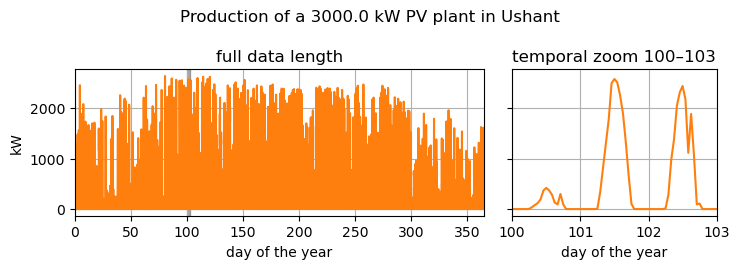

In [20]:
if with_plots
    fig, (ax1, ax2) = plot_ts_zoom(
        td, production(photovoltaic);
        zoom=(100,103), color="tab:orange",
        title="Production of a $power_rated_pv kW PV plant in Ushant",
        xlabel="day of the year", ylabel="kW"
    )
end;

### Wind power generation

Used in priority to feed the load along solar power.

The simple wind power model use the fixed capacity factor data derived from wind speed in the previous section.

In [21]:
power_rated_wind = 1800. # rated power (kW)
investment_price_wind = 3500. # initial investiment price ($/kW)
om_price_wind = 100.# operation and maintenance price ($/kW/y)
lifetime_wind = 25. # lifetime (y)

windgen = WindPower(power_rated_wind, cf_wind,
    investment_price_wind, om_price_wind,
    lifetime_wind,
    replacement_price_ratio, salvage_price_ratio)

WindPower{Float64}(1800.0, [0.03184904690521816, 0.1104932647748532, 0.24596484619739856, 0.44422012231738006, 0.6554128208926687, 0.8470913237698507, 0.9579413031865969, 0.9735278942424532, 0.9837469734016646, 0.9903667231838823  …  0.011233045262998936, 0.018460507449516883, 0.023644167600765466, 0.02969747711584798, 0.036359043012900244, 0.03713796382151399, 0.037530379586714784, 0.03792477182913709, 0.037530379586714784, 0.03674751985711801], 3500.0, 100.0, 25.0, 1.0, 1.0)

Display wind power time series:
- Wind production is computed by calling the `production` method on the `WindPower` instance

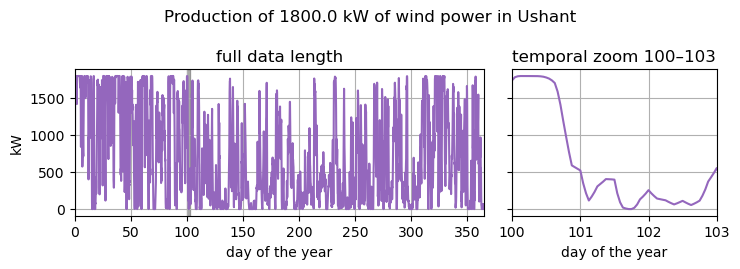

In [22]:
if with_plots
    fig, (ax1, ax2) = plot_ts_zoom(
        td, production(windgen);
        zoom=(100,103), color="tab:purple",
        title="Production of $power_rated_wind kW of wind power in Ushant",
        xlabel="day of the year", ylabel="kW"
    )
end;

### Microgrid data structure

the `Microgrid` data structure groups:
- project parameters
- load time series
- all components: energy storage systems, renewable power generators, 

In [23]:
[elyz,]

1-element Vector{ProductionUnit{Float64}}:
 ProductionUnit{Float64}(2000.0, 0.0, 56.0, 0.0, 1000.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "KWh", "Kg")

In [24]:


microgrid = Microgrid(project, Pload,dispatchables,
    [elyz,],tanks,battery, [
        photovoltaic,
        windgen
    ]
)

Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1453.0, 1331.0, 1214.0, 1146.0, 1078.0, 1035.0, 1032.0, 1072.0, 1142.0, 1208.0  …  1479.0, 1508.0, 1410.0, 1370.0, 1467.0, 1587.0, 1561.0, 1472.0, 1533.0, 1483.0], DispatchableCompound{Float64}(ProductionUnit{Float64}[ProductionUnit{Float64}(0.0, 0.0, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L", "KWh")], ProductionUnit{Float64}[ProductionUnit{Float64}(1800.0, 0.0, 0.0625, 0.0, 1000.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "Kg", "KWh")]), ProductionUnit{Float64}[ProductionUnit{Float64}(2000.0, 0.0, 56.0, 0.0, 1000.0, 10.0, 45000.0, 0.05, 1.0, 1.0, "KWh", "Kg")], TankCompound{Float64}(Tank{Float64}(0.0, 0.0, 0.0, 25.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0), Tank{Float64}(10000.0, 0.8, 0.0025, 25.0, 0.0, 0.0, 0.2, 1.0, 1.0, 1.0)), Battery{Float64}(5000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 1.0, 0.05, 0.0, 1.0, 0.0, 1.0, 1.0), NonDispatchableSource[Photovoltaic{Float64}(3000.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.000000000000001e-5  …  0.4

## Simulate the microgrid

launched with the `simulate` method:

In [25]:
oper_traj, oper_stats, mg_costs = simulate(microgrid);

In details, the simulation is done in two stages:

1. simulate the **operation**, in particular the energy flow at an hourly timestep between components: 
    - generates operation statistics as `OperationStats` data structure
    - records trajectories of operation variables
2. evaluate the **economic cost** of the project, based on its description and on the operation statistics: 
    - generates cost data as `MicrogridCosts` data structure

These successive stages can be run manually with their dedicated functions (see `simulate` code).

Microgrid simulation code is optimized to run in less than 1 ms:

(you can use [Benchmarktools](https://juliaci.github.io/BenchmarkTools.jl/)'s `@btime` for more accurate timing results)

In [26]:
using BenchmarkTools

In [27]:
43850   /8760

5.005707762557078

In [31]:
?ProductionUnit

search: ProductionUnit production



Dispatchable power source (e.g. Diesel generator, Gas turbine, Fuel cell or )

All component parameters should be `Float64` except for the *sizing parameter(s)* (here `power_rated`) which type is parametrized as `Topt` and may be also `Float64` or or any another `Real` type (e.g. ForwardDiff's dual number type).

```julia
struct ProductionUnit{Topt<:Real}
```

**parameters** : 

  * `power_rated`: rated power (kW)
  * `consumption_intercept`: combustible consumption curve intercept (L/h/kW_max  ) 0for fuel cells and electrolyzer as the models used are linear
  * `consumption_slope`: input consumption curve slope (L/h/kW or Kg/h/kW or KW/Kg/h )
  * `combustible_price`: fuel price (:/L)
  * `investment_price`: initial investiment price (:/kW)
  * `om_price_hours`: operation & maintenance price (:/kW/h of operation)
  * `lifetime_hours`: generator lifetime (h of operation)
  * `minimum_load_ratio`: minimum load ratio ∈ [0,1]
  * `replacement_price_ratio`: replacement price, relative to initial investment
  * `salvage_price_ratio`: salvage price, relative to initial investment
  * `input_unit`: fuel quantity unit (used in fuel price and consumption curve parameters)
  * `output_unit`


In [28]:
@btime oper_traj = operation(microgrid);

  1.920 ms (43850 allocations: 3.81 MiB)


In [28]:
@btime oper_traj = operation(microgrid);

  1.918 ms (43850 allocations: 3.81 MiB)


In [27]:
@btime oper_traj = operation(microgrid);

  2.133 ms (52609 allocations: 4.35 MiB)


In [28]:
@btime oper_traj, oper_stats, mg_costs = simulate(microgrid);

  3.186 ms (79057 allocations: 5.96 MiB)


In [34]:
@code_warntype operation(microgrid);

MethodInstance for Microgrids.operation(::Microgrid{Float64})
  from operation(mg::Microgrid) @ Microgrids C:\Users\nikiemaje\Documents\Macopie\Microgrids.jl\src\operation.jl:193
Arguments
  #self#::Core.Const(Microgrids.operation)
  mg::Microgrid{Float64}
Locals
  @_3::Union{Nothing, Tuple{Int64, Int64}}
  #15::Microgrids.var"#15#35"
  #14::Microgrids.var"#14#34"{Microgrid{Float64}, Vector{Float64}}
  #13::Microgrids.var"#13#33"
  #12::Microgrids.var"#12#32"
  #11::Microgrids.var"#11#31"{Microgrid{Float64}, Vector{Float64}}
  #10::Microgrids.var"#10#30"
  #9::Microgrids.var"#9#29"
  #8::Microgrids.var"#8#28"
  #7::Microgrids.var"#7#27"{Microgrid{Float64}, Vector{Float64}}
  #6::Microgrids.var"#6#26"
  #5::Microgrids.var"#5#25"
  oper_traj::OperationTraj{Float64}
  LoF_ini::Float64
  LoH_ini::Float64
  Esto_ini::Float64
  LoF::Vector{Float64}
  LoH::Vector{Float64}
  Pfc::Matrix{Float64}
  Pelyz::Matrix{Float64}
  Pshed::Vector{Float64}
  Pspill::Vector{Float64}
  Psto::Vector{Float64}

In [30]:
?@code_warntype

```
@code_warntype
```

Evaluates the arguments to the function or macro call, determines their types, and calls [`code_warntype`](@ref) on the resulting expression.


## Analyze Microgrid simulation results

### Technical performance

Operation statistics are in `oper_stats` (`OperationStats` data structure) with fields such as `renew_rate` (fraction of renewables in the energy mix), `shed_rate` (fraction of shed, i.e. unserved load)...

In [31]:
@printf("Load shedding rate: %.1f%%\n", oper_stats.shed_rate*100)
@printf("Renewable rate: %.1f%%\n", oper_stats.renew_rate*100)

Load shedding rate: 3.1%
Renewable rate: 100.0%


All available statistics:

In [32]:
oper_traj.Pbatt[3000]

1041.8586431923732

In [26]:
oper_stats

OperationStats with fields:
- served_energy: 6.5642e6 kWh
- shed_energy: 210820.0 kWh
- shed_max: 33396.0 kW
- shed_hours: 306.0 h
- shed_duration_max: 56.0 h
- shed_rate: 0.031117 in [0,1]
- gen_energy: 0.0 kWh
- gen_hours: 0.0 h
- gen_fuel: 0.0 L
- fc_energy: 626880.0 kWh
- fc_hours: 1215.0 h
- h2_consumed: 39180.0 kg
- h2_produced: 41180.0 kg
- elyz_hours: 2667.0 h
- elyz_consumed_energy: 2.3061e6 kWh
- h2_chain_loss: 1.6791e6 kWh
- storage_cycles: 157.88 
- storage_char_energy: 828880.0 kWh
- storage_dis_energy: 749940.0 kWh
- storage_loss_energy: 78941.0 kWh
- spilled_energy: 1.0453e6 kWh
- spilled_max: 3413.9 kW
- spilled_rate: 0.11159 in [0,1]
- renew_potential_energy: 9.3676e6 kWh
- renew_energy: 8.3223e6 kWh
- renew_rate: 1.0 in [0,1]


In [34]:
oper_traj.LoH[7680]

3148.701693426455

### Economic performance

Economic performance indicators are stored in `mg_costs` (as a `MicrogridCosts` data structure). This structure contains the following fields:
- two highlevel cost indicators: Net present Cost `npc` and Levelized Costs of Electricity `lcoe`
- a break down of cost factors for the entire project in `system`: initial investment, fuel... (as a `CostFactors` structure)
- a detailed break down of cost factors for each component in `generator`, `storage`, `nondispatchables[n]`... (also as `CostFactors` structures)

In [32]:
@printf("Levelized Cost of Electricity: %.3f \$/kWh\n", mg_costs.lcoe)
@printf("Net Present Cost: %.2f M\$ (over %d years at %.0f%% discount rate)\n",
    mg_costs.npc/1e6, project.lifetime, project.discount_rate*100)

Levelized Cost of Electricity: 0.253 $/kWh
Net Present Cost: 23.00 M$ (over 25 years at 5% discount rate)


Break down of cost factors for the entire project:

In [33]:
mg_costs.system

CostFactors(2.2999237665849324e7, 1.5458e7, 3.636477520274991e6, 4.623166166276827e6, 0.0, -718406.0207024994)

Break down of cost factors for each nondispatchable power sources (i.e. renewables), in the same order as in `microgrid.nondispatchables`:

In [57]:
mg_costs.nondispatchables

2-element Vector{CostFactors}:
 CostFactors(4.445636673962684e6, 3.6e6, 0.0, 845636.6739626848, 0.0, -0.0)
 CostFactors(8.836910021888055e6, 6.3e6, 0.0, 2.5369100218880544e6, 0.0, -0.0)

Definition of the fields of cost factors (`total` is the sum of all the other ones):

In [58]:
fieldnames(CostFactors)

(:total, :investment, :replacement, :om, :fuel, :salvage)

Remark 1: `npc` is equal to `system.total`

Remark 2: `CostFactors` structures like `mg_costs.system` support arithmetic operations (+,*,/) and rounding:

In [59]:
round(mg_costs.system/1e6; digits=2) # rounded costs in M$

CostFactors(23.0, 15.46, 3.64, 4.62, 0.0, -0.72)

Individual cost factors can be accessed by field names. For examples fuel costs for the dispatchable generator:

In [60]:
round(mg_costs.fuel_cell/1e6; digits=2) # M$

CostFactors(2.5, 1.8, 0.76, 0.25, 0.0, -0.31)

In [61]:
round(mg_costs.electrolyzer/1e6; digits=2) # M$

CostFactors(4.09, 2.0, 2.04, 0.28, 0.0, -0.23)

### Operation trajectories

`oper_traj` is of type `OperationTraj` with fields such as `Pgen` (generator power), `Pbatt` (battery power)...

**Graph 1** Zoom to first week of January: high load, wind at maximum, few solar → battery often empty

In [33]:
function plot_oper_traj(microgrid, oper_traj)
    fig, (ax1, ax2) = plt.subplots(2,1, sharex=true)
    ax1.plot(td, Pload, label="load")
    ax1.plot(td, oper_traj.Pfc, "tab:red", label="Pfc")
    ax1.plot(td, oper_traj.Prenew_pot, "tab:orange", label="ren")
    ax1.plot(td, oper_traj.Pelyz, "tab:gray", label="Pelyz")
    ax1.plot(td, oper_traj.Pfc, "tab:pink", label="Pfc")
     ax3=ax1.twinx()
     ax3.set_ylim([0, 1])
    ax3.plot(td, oper_traj.Ebatt[1:end-1]/5000, "C2")
    
    ax1.legend()
    ax1.grid(true)
    ax1.set(
        ylabel="kW"
    )
   
    ax2.grid(true)
    ax2.set(
        title="H2 Tank level",
        xlabel="time (d)",
        ylabel="kWh"
       
    )
   
    ax2.plot(td, oper_traj.LoH[1:end-1]/10000, "C2")
    
    fig.tight_layout()
    return fig, (ax1, ax2)
end

if with_plots
    fig, (ax1, ax2) = plot_oper_traj(microgrid, oper_traj)
     ax1.set_ylim(0, 5000)
    pygui(true)
    plt.show()
   
end;

In [63]:
mean(reshape(Pload, 24, :); dims=1)

1×365 Matrix{Float64}:
 1310.75  1202.75  1040.17  1018.17  …  1214.92  1354.92  1416.79  1409.08

In [64]:
?reshape

search: reshape promote_shape



```
reshape(A, dims...) -> AbstractArray
reshape(A, dims) -> AbstractArray
```

Return an array with the same data as `A`, but with different dimension sizes or number of dimensions. The two arrays share the same underlying data, so that the result is mutable if and only if `A` is mutable, and setting elements of one alters the values of the other.

The new dimensions may be specified either as a list of arguments or as a shape tuple. At most one dimension may be specified with a `:`, in which case its length is computed such that its product with all the specified dimensions is equal to the length of the original array `A`. The total number of elements must not change.

# Examples

```jldoctest
julia> A = Vector(1:16)
16-element Vector{Int64}:
  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
 11
 12
 13
 14
 15
 16

julia> reshape(A, (4, 4))
4×4 Matrix{Int64}:
 1  5   9  13
 2  6  10  14
 3  7  11  15
 4  8  12  16

julia> reshape(A, 2, :)
2×8 Matrix{Int64}:
 1  3  5  7   9  11  13  15
 2  4  6  8  10  12  14  16

julia> reshape(1:6, 2, 3)
2×3 reshape(::UnitRange{Int64}, 2, 3) with eltype Int64:
 1  3  5
 2  4  6
```


**Graph 2** Zoom to one week in summer: much solar → battery often full → spillage

In [65]:
if with_plots
    fig, (ax1, ax2) = plot_oper_traj(microgrid, oper_traj)
    ax1.set_xlim(150, 151)
end;

---
**Next steps**: 
after this demonstration which focused on Microgrid *simulation*, you can go to the [Microgrid sizing optimization](Microgrid_sizing_optimization.ipynb).